# Feature Engineering from Just Latitude and Longitude

The purpose of this notebook is to demonstrate a few feature engineering techniques that use only latitude and longitude.

It compares these feature engineering techniques by using them on a prediction problem from Kaggle, "Predicting Airbnb Prices" ([dataset](https://www.kaggle.com/datasets/kritikseth/us-airbnb-open-data)).

Tools used include `polars`, `numpy`, `matplotlib`, `xgboost`, `scikit-learn`, and `scipy`.

## 0. Env

#### Imports

In [1]:
import os
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import root_mean_squared_error
import geohash2
from scipy import spatial
import plotly.graph_objects as go
import plotly.express as px
from typing import List, Optional

#### Constants

In [2]:
home = "../.."
images_dir = os.path.join(home, "static/images/")

In [3]:
TRAIN_TEST_SPLIT_FRACTION = 0.8
MODEL_TARGET = "price_log10"
GEOHASH_PRECISION = 6

#### Helper Functions

In [4]:
def plot_geo_df(
    geo_df: pl.DataFrame,
    colorby_column: str,
    colorbar_tickvals: List[int],
    colorbar_ticktext: List[str],
    plot_title: str,
    range_color: Optional[List[int]] = None,
):
    df_sample = geo_df.sample(fraction=.2, shuffle=True)
    range_color = [1, int(geo_df[colorby_column].max()) + 1] if not range_color else range_color
    fig = px.scatter_mapbox(
        data_frame=df_sample,
        lat="latitude",
        lon="longitude",
        color=colorby_column,
        range_color=range_color
    )
    fig.update_layout(
        mapbox_style="carto-positron",
        margin={"r":0, "t":0, "l":0, "b":0},
        mapbox_bounds={
            "west": -74.108,
            "east": -73.763,
            "south": 40.565,
            "north": 40.886,
        },
        coloraxis_colorbar={
            "title": plot_title,
            "tickvals": colorbar_tickvals,
            "ticktext": colorbar_ticktext,
        },
    )
    fig.write_image(os.path.join(images_dir, f"nyc-{plot_title.lower().replace(' ', '-')}.png"))
#     fig.show()

## 1. Load Data

#### Choosing a target city for the problem... which city has the most data?

In [5]:
(
    pl.read_csv("../data/AB_US_2023.csv")
    ["city"]
    .value_counts()
    .sort(by="count", descending=True)
    .head(5)
)

city,count
str,u32
"""New York City""",42931
"""Los Angeles""",42451
"""Broward County…",16899
"""Austin""",14368
"""Clark County""",13933


#### Load data for New York City

Normally we'd have to do `log1p`, but we can be quite certain here that nobody will be offering their Airbnb for free!

In [6]:
df_query = (
    pl.scan_csv("../data/AB_US_2023.csv")
    .filter(pl.col("city") == "New York City")
    .select(pl.col(["latitude", "longitude", "price"]))
    .with_columns((pl.col("price") + 1).log10().name.suffix("_log10"))
)

In [7]:
num_rows = df_query.collect().shape[0]
df = (
    df_query.collect()
    # .sample(fraction=1, shuffle=True)
    .with_row_index(name="row_number")
    .with_columns([
        (pl.col("row_number") < TRAIN_TEST_SPLIT_FRACTION * num_rows).alias("is_train")
    ])
)

#### Viewing the data

In [8]:
display(
    df
    .head()
)

row_number,latitude,longitude,price,price_log10,is_train
u32,f64,f64,i64,f64,bool
0,40.75356,-73.98559,150,2.178977,true
1,40.68535,-73.95512,60,1.78533,true
2,40.8038,-73.96751,75,1.880814,true
3,40.76457,-73.98317,68,1.838849,true
4,40.66265,-73.99454,275,2.440909,true


## 2. Brief EDA

#### Distribution of Prices

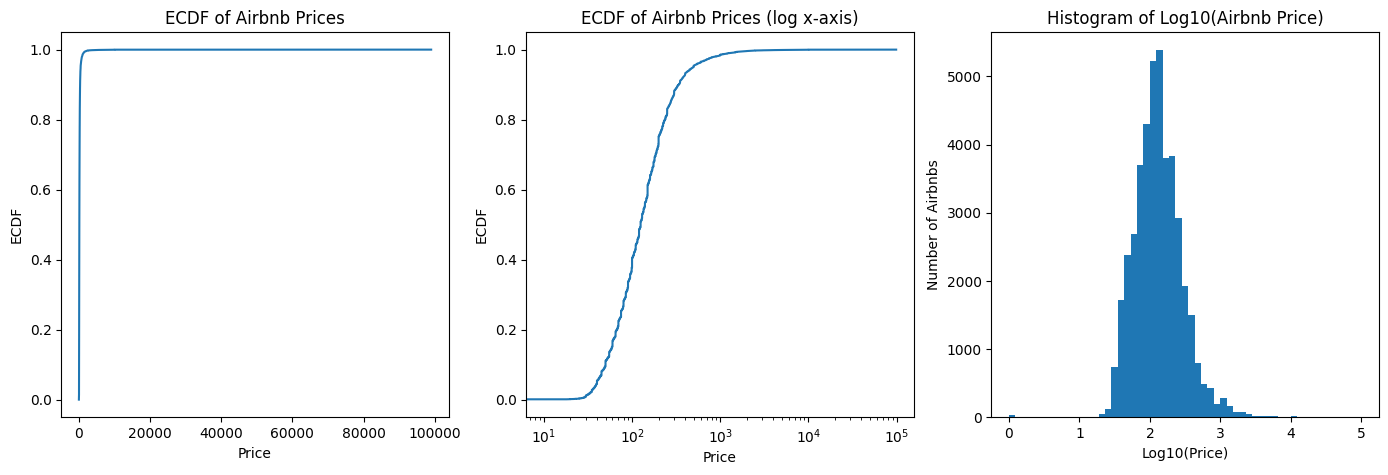

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))

ax1.plot(df["price"].sort(), np.linspace(0, 1, len(df)))
ax1.set_xlabel("Price")
ax1.set_ylabel("ECDF")
ax1.set_title("ECDF of Airbnb Prices")

ax2.plot(df["price"].sort(), np.linspace(0, 1, len(df)))
ax2.set_xscale("log")
ax2.set_xlabel("Price")
ax2.set_ylabel("ECDF")
ax2.set_title("ECDF of Airbnb Prices (log x-axis)")

ax3.hist(df["price_log10"], bins=55, density=False)
ax3.set_xlabel("Log10(Price)")
ax3.set_ylabel("Number of Airbnbs")
ax3.set_title("Histogram of Log10(Airbnb Price)")

plt.savefig(os.path.join(images_dir, "distribution-of-airbnb-price.png"))

#### Distribution over Space

In [10]:
plot_geo_df(
    df,
    colorby_column="price_log10",
    colorbar_tickvals=[1, 2, 3, 4, 5, 6],
    colorbar_ticktext=["$10", "$100", "$1K", "$10K", "$100K"],
    plot_title="Airbnb Prices",
)

#### Correlation

In [11]:
df.select(["latitude", "longitude", "price"]).corr()

latitude,longitude,price
f64,f64,f64
1.0,0.046993,0.008133
0.046993,1.0,-0.058381
0.008133,-0.058381,1.0


## 3. Feature Engineering Experiments

### 3.0 Setup

In [12]:
MODEL_PERFORMANCE_LIST = []

In [13]:
X_train = df.filter(pl.col("is_train"))#.select(MODEL_FEATURE_LIST)
y_train = df.filter(pl.col("is_train"))#.select(MODEL_TARGET)
X_test = df.filter(~pl.col("is_train"))#.select(MODEL_FEATURE_LIST)
y_test = df.filter(~pl.col("is_train"))#.select(MODEL_TARGET).to_numpy()

### 3.1 Raw Latitude and Longitude

In [14]:
MODEL_FEATURE_LIST_NAME = "raw_lat_lon"
MODEL_FEATURE_LIST = ["latitude", "longitude"]

for model_name, model_class in zip(
    ["xgboost", "ridge regression"],
    [XGBRegressor, Ridge]
):
    model = model_class().fit(
        X_train.select(MODEL_FEATURE_LIST),
        y_train.select(MODEL_TARGET)
    )
    y_predicted = model.predict(X_test.select(MODEL_FEATURE_LIST))
    model_performance = root_mean_squared_error(y_test.select(MODEL_TARGET), y_predicted)
    model_result = {
        "feature_list_name": MODEL_FEATURE_LIST_NAME,
        "model_name": model_name,
        "model_performance": model_performance
    }
    print(model_result)
    MODEL_PERFORMANCE_LIST.append(model_result)

{'feature_list_name': 'raw_lat_lon', 'model_name': 'xgboost', 'model_performance': 0.3252347470774259}
{'feature_list_name': 'raw_lat_lon', 'model_name': 'ridge regression', 'model_performance': 0.36949645137312853}


### 3.2 Neighborhood Density

In [15]:
def add_density_feature_columns_to_dataframe(geo_df: pl.DataFrame) -> pl.DataFrame:
    tree = spatial.cKDTree(df.select(["latitude", "longitude"]))
    result = geo_df.with_columns(
        pl.Series(
            "spatial_density",
            tree.query_ball_point(geo_df.select(["latitude", "longitude"]), .005, return_length=True)
        )
    )
    return result

In [16]:
df_w_density = add_density_feature_columns_to_dataframe(df)
plot_geo_df(
    df_w_density,
    colorby_column="spatial_density",
    colorbar_tickvals=None,
    colorbar_ticktext=None,
    plot_title="Airbnb Spatial Density",
)

In [17]:
MODEL_FEATURE_LIST_NAME = "spatial_density"
MODEL_FEATURE_LIST = ["spatial_density"]

X_train = df_w_density.filter(pl.col("is_train")).select(MODEL_FEATURE_LIST)
y_train = df_w_density.filter(pl.col("is_train")).select(MODEL_TARGET)
X_test = df_w_density.filter(~pl.col("is_train")).select(MODEL_FEATURE_LIST)
y_test = df_w_density.filter(~pl.col("is_train")).select(MODEL_TARGET).to_numpy()

for model_name, model_class in zip(
    ["xgboost", "ridge regression"],
    [XGBRegressor, Ridge]
):
    model = model_class().fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    model_performance = root_mean_squared_error(y_test, y_predicted)
    model_result = {
        "feature_list_name": MODEL_FEATURE_LIST_NAME,
        "model_name": model_name,
        "model_performance": model_performance
    }
    print(model_result)
    MODEL_PERFORMANCE_LIST.append(model_result)

{'feature_list_name': 'spatial_density', 'model_name': 'xgboost', 'model_performance': 0.36708661879227245}
{'feature_list_name': 'spatial_density', 'model_name': 'ridge regression', 'model_performance': 0.3655968169555768}


### 3.3 Geohash Target Encoding

In [18]:
def add_geohash_column_to_df(geo_df: pl.DataFrame) -> pl.DataFrame:
    result = (
        df
        .with_columns(
            df
            .select("latitude", "longitude")
            .map_rows(
                lambda x: geohash2.encode(x[0], x[1], precision=5),
                return_dtype=pl.Utf8
            )
            .rename({"map": "geohash"})
        )
    )
    return result


def add_target_encoding_to_df(
    dataframe: pl.DataFrame,
    categorical_column: str = "geohash"
) -> pl.DataFrame:
    category_target_means = (
        dataframe
        .filter(pl.col("is_train"))  # Only include train data to prevent test data leakage.
        .group_by(categorical_column)
        .agg(
            pl.col(MODEL_TARGET).mean().alias(f"{categorical_column}_{MODEL_TARGET}_mean")
        )
    )
    result = (
        dataframe
        .join(
            category_target_means,
            how="left",
            on=categorical_column
        )
    )
    return result

In [19]:
df_w_geohash = add_geohash_column_to_df(df)
df_w_geohash_target_encoded = add_target_encoding_to_df(df_w_geohash)

plot_geo_df(
    geo_df=df_w_geohash_target_encoded,
    colorby_column=f"geohash_{MODEL_TARGET}_mean",
    colorbar_tickvals=[1, 2, 3, 4,],
    colorbar_ticktext=["$10", "$100", "$1K", "$10K"],
    plot_title="Airbnb Geohash Price",
    range_color=[1.5, 3]
)

In [20]:
MODEL_FEATURE_LIST_NAME = "geohash_target_encoding"
MODEL_FEATURE_LIST = [
    "geohash_price_log10_mean",
]

X_train = df_w_geohash_target_encoded.filter(pl.col("is_train")).select(MODEL_FEATURE_LIST)
y_train = df_w_geohash_target_encoded.filter(pl.col("is_train")).select(MODEL_TARGET)
X_test = df_w_geohash_target_encoded.filter(~pl.col("is_train")).select(MODEL_FEATURE_LIST)
y_test = df_w_geohash_target_encoded.filter(~pl.col("is_train")).select(MODEL_TARGET).to_numpy()

for model_name, model_class in zip(
    ["xgboost", "ridge regression"],
    [XGBRegressor, Ridge]
):
    model = model_class().fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    model_performance = root_mean_squared_error(y_test, y_predicted)
    model_result = {
        "feature_list_name": MODEL_FEATURE_LIST_NAME,
        "model_name": model_name,
        "model_performance": model_performance
    }
    print(model_result)
    MODEL_PERFORMANCE_LIST.append(model_result)

{'feature_list_name': 'geohash_target_encoding', 'model_name': 'xgboost', 'model_performance': 0.33247380408202365}
{'feature_list_name': 'geohash_target_encoding', 'model_name': 'ridge regression', 'model_performance': 0.3325121541141616}


### 3.4 All the features together

In [21]:
df_w_all_features = add_density_feature_columns_to_dataframe(
    add_target_encoding_to_df(
        add_geohash_column_to_df(df)
    )
)

MODEL_FEATURE_LIST_NAME = "all_features"
MODEL_FEATURE_LIST = [
    "latitude",
    "longitude",
    "spatial_density",
    "geohash_price_log10_mean",
]

X_train = df_w_all_features.filter(pl.col("is_train")).select(MODEL_FEATURE_LIST)
y_train = df_w_all_features.filter(pl.col("is_train")).select(MODEL_TARGET)
X_test = df_w_all_features.filter(~pl.col("is_train")).select(MODEL_FEATURE_LIST)
y_test = df_w_all_features.filter(~pl.col("is_train")).select(MODEL_TARGET).to_numpy()

for model_name, model_class in zip(
    ["xgboost", "ridge regression"],
    [XGBRegressor, Ridge]
):
    model = model_class().fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    model_performance = root_mean_squared_error(y_test, y_predicted)
    model_result = {
        "feature_list_name": MODEL_FEATURE_LIST_NAME,
        "model_name": model_name,
        "model_performance": model_performance
    }
    print(model_result)
    MODEL_PERFORMANCE_LIST.append(model_result)

{'feature_list_name': 'all_features', 'model_name': 'xgboost', 'model_performance': 0.32453200273943666}
{'feature_list_name': 'all_features', 'model_name': 'ridge regression', 'model_performance': 0.33275123037696347}


### 3.5 Summary

In [43]:
results_feature_set_order = [
    "raw_lat_lon",
    "spatial_density",
    "geohash_target_encoding",
    "all_features"
]

In [44]:
results_summary_df = (
    pd.DataFrame
    .from_records(MODEL_PERFORMANCE_LIST)
    .pivot_table(
        index="feature_list_name",
        columns="model_name",
        values="model_performance",
        aggfunc="first"
    )
)
results_summary_df.columns.name = None
results_summary_df.index.name = None

In [45]:
print(
    results_summary_df
    .loc[results_feature_set_order, :]
    .style
    .format("{:.4f}")
    .background_gradient(vmin=0.3, vmax=0.4)
    .to_html()
)

<style type="text/css">
#T_8ee67_row0_col0 {
  background-color: #1b7eb7;
  color: #f1f1f1;
}
#T_8ee67_row0_col1 {
  background-color: #d0d1e6;
  color: #000000;
}
#T_8ee67_row1_col0 {
  background-color: #2a88bc;
  color: #f1f1f1;
}
#T_8ee67_row1_col1 {
  background-color: #2484ba;
  color: #f1f1f1;
}
#T_8ee67_row2_col0, #T_8ee67_row2_col1, #T_8ee67_row3_col0 {
  background-color: #b7c5df;
  color: #000000;
}
#T_8ee67_row3_col1 {
  background-color: #d2d2e7;
  color: #000000;
}
</style>
<table id="T_8ee67">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_8ee67_level0_col0" class="col_heading level0 col0" >ridge regression</th>
      <th id="T_8ee67_level0_col1" class="col_heading level0 col1" >xgboost</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_8ee67_level0_row0" class="row_heading level0 row0" >raw_lat_lon</th>
      <td id="T_8ee67_row0_col0" class="data row0 col0" >0.3695</td>
      <td id="T_8ee67_row0_col1" class="data row0 col1" >0

# Scratch

In [ ]:
# def add_geohash_one_hot_encoded_category_columns_to_dataframe(
#     geo_df: pl.DataFrame,
#     geohash_precision=6
# ) -> pl.DataFrame:
#     result = (
#         add_geohash_category_column_to_dataframe(
#             geo_df,
#             geohash_precision=geohash_precision
#         )
#         .to_dummies(columns="geohash")
#     )
#     return result

In [ ]:
# df_w_geohash_ohe = add_geohash_one_hot_encoded_category_columns_to_dataframe(df)
# display(df_w_geohash_ohe.head())
# display(df_w_geohash_ohe.filter(pl.col("is_train")).head())

# MODEL_FEATURE_PATTERN = "^geohash_.*$"

# X_train = df_w_geohash_ohe.filter(pl.col("is_train")).select(pl.col(MODEL_FEATURE_PATTERN))
# y_train = df_w_geohash_ohe.filter(pl.col("is_train")).select(MODEL_TARGET)
# X_test = df_w_geohash_ohe.filter(~pl.col("is_train")).select(pl.col(MODEL_FEATURE_PATTERN))
# y_test = df_w_geohash_ohe.filter(~pl.col("is_train")).select(MODEL_TARGET).to_numpy()

# for model_name, model_class in zip(
#     ["xgboost", "ridge regression"],
#     [XGBRegressor, Ridge]
# ):
#     model = model_class().fit(X_train, y_train)
#     y_predicted = model.predict(X_test)
#     print(f"{model_name}, {mean_squared_error(y_test, y_predicted):.7f} (sklearn)")

In [ ]:
# geohash_categorical_results_df = (
#     pd.DataFrame
#     .from_records(model_performance_list)
#     .pivot_table(
#         index="feature_list_name",
#         columns="model_name",
#         values="model_performance",
#         aggfunc="first"
#     )
# )

# display(
#     pd.concat([
#         raw_lat_lon_results_df,
#         spatial_density_results_df,
#         geohash_categorical_results_df
#     ])
#     .style
#     .format("{:.3f}")
#     .background_gradient(vmin=0, vmax=1)
#     .to_html()
# )

In [ ]:


# print()
# raw_lat_lon_results_df = (
#     pd.DataFrame
#     .from_records(model_performance_list)
#     .pivot_table(
#         index="feature_list_name",
#         columns="model_name",
#         values="model_performance",
#         aggfunc="first"
#     )
# )
# raw_lat_lon_results_df.index.name = None
# raw_lat_lon_results_df.columns.name = None
# raw_lat_lon_results_df = 10 ** raw_lat_lon_results_df

# display(
#     raw_lat_lon_results_df
#     .style
# #     .format("{:.2f}")
#     .background_gradient(vmin=0, vmax=1)
#     # .to_html()
# )